<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Evaluation-of-single-cell-detectors-in-Lens-free-vs.-Brightfield-microscopy-images" data-toc-modified-id="Evaluation-of-single-cell-detectors-in-Lens-free-vs.-Brightfield-microscopy-images-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Evaluation of single cell detectors in Lens-free vs. Brightfield microscopy images</a></span><ul class="toc-item"><li><span><a href="#Setup-model-and-data-path" data-toc-modified-id="Setup-model-and-data-path-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Setup model and data path</a></span></li></ul></li><li><span><a href="#Perfomance-on-validation-data" data-toc-modified-id="Perfomance-on-validation-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Perfomance on validation data</a></span><ul class="toc-item"><li><span><a href="#Predicting-and-Evaluating" data-toc-modified-id="Predicting-and-Evaluating-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Predicting and Evaluating</a></span></li><li><span><a href="#Plotting-evaluation-metrics" data-toc-modified-id="Plotting-evaluation-metrics-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Plotting evaluation metrics</a></span></li><li><span><a href="#Plot-confusion-matrix" data-toc-modified-id="Plot-confusion-matrix-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Plot confusion matrix</a></span></li><li><span><a href="#Show-predicted-image" data-toc-modified-id="Show-predicted-image-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Show predicted image</a></span></li></ul></li><li><span><a href="#Evaluation-on-different-confluencys" data-toc-modified-id="Evaluation-on-different-confluencys-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Evaluation on different confluencys</a></span></li></ul></div>

# Evaluation of single cell detectors in Lens-free vs. Brightfield microscopy images

This notebook evaluates based on:
- Mean Average Precision ($mAP$) defined as in [VOC2012](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/htmldoc/devkit_doc.html#SECTION00054000000000000000)
- $F_1$-Score
- Confusion Matrix
- Visual inspection
- Different confluencys

All metrics are defined as in [Wikipedia Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).  


Default setting for determining a true positive is an $IoU >= 0.5$. 
____

In [1]:
from pathlib import Path

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Own scripts
from data.tf_record_loading import tf_dataset_generator
from prediction import simple_confluency, prediction_utils
from statistics import get_performance_metrics
from visualization import plot_circles_from_boxes

In [16]:
# Set default figure size
matplotlib.rcParams['figure.figsize'] = (12, 6)

____

**HELPER FUNCTIONS**

In [2]:
def evaluate_on_series(model, data, iou=0.5):
    """
    Get evaluation metrics on all images in data
    
    :param model: tf_model
    :param data: list/generator of dict with keys: ["name(s)", "image(s)", "bboxes"]
    :return: list of dict with metrics
    """
    metrics = []

    for query in data:
        print(Path(query.get("name").decode("utf-8")).name, end="\r")
        image = query.get("image")
        gt_boxes = query.get("bboxes")

        pred_boxes = prediction_utils.run_inference_for_single_image(model, image)
        pred_boxes = pred_boxes.get("detection_boxes")#[pred_boxes.get("detection_scores") >= 0.5]
        metrics.append(get_performance_metrics(pred_boxes, gt_boxes, iou=iou))
    
    return metrics

##  Setup model and data path 

In [3]:
# Model should be exported tensorflow model. (Must contain: saved_model subfolder, model.ckpt, frozen_inference_graph)
LF_MODEL_PATH = Path(r"D:\Nabil_object_detection\models\graph_imgSize_vs_bboxSize\ssd_resnet50_v1_fpn_z00_tiles0_bboxes40")
BF_MODEL_PATH = Path(r"D:\Nabil_object_detection\models\graph_imgSize_vs_bboxSize\ssd_resnet50_v1_fpn_10x_tiles0_bboxes40")

# TF Records as generated by data.tf_record_writer. data.tf_dataset_generator(laod_tf_dataset) will produce keys: ["name(s)", "image(s)", "bboxes"]
LF_DATA_PATH = Path(r"D:\Nabil_object_detection\data\experiments\tiles_vs_bboxes\nrk\z00_tiles0_bboxes40.tfrecord")
BF_DATA_PATH = Path(r"D:\Nabil_object_detection\data\experiments\tiles_vs_bboxes\nrk\10x_tiles0_bboxes40.tfrecord") # Needed for confluency prediction

# Perfomance on validation data

## Predicting and Evaluating

In [4]:
lf_model = prediction_utils.load_model(LF_MODEL_PATH)
bf_model = prediction_utils.load_model(BF_MODEL_PATH)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [5]:
lf_val_data_generator = tf_dataset_generator(LF_DATA_PATH)
bf_val_data_generator = tf_dataset_generator(BF_DATA_PATH)

In [6]:
lf_metrics = evaluate_on_series(lf_model, lf_val_data_generator)
bf_metrics = evaluate_on_series(bf_model, bf_val_data_generator)

## Plotting evaluation metrics

In [8]:
# Show all measured metrics

print(lf_metrics[0].keys())

# Get metrics over time
lf_fdrs = [i.get("fdr") for i in lf_metrics]
lf_fnrs = [i.get("fnr") for i in lf_metrics]
lf_maps = [i.get("map") for i in lf_metrics]
lf_fscores = [i.get("fscore") for i in lf_metrics]

bf_fdrs = [i.get("fdr") for i in bf_metrics]
bf_fnrs = [i.get("fnr") for i in bf_metrics]
bf_maps = [i.get("map") for i in bf_metrics]
bf_fscores = [i.get("fscore") for i in bf_metrics]

dict_keys(['tp', 'fn', 'fp', 'recall', 'precision', 'recalls', 'precisions', 'fnr', 'fdr', 'map', 'auc', 'fscore'])


In [13]:
frames = list(range(len(lf_fdrs)))

frame_time = 20 # in minutes
time = (np.array(frames) * frame_time) / 60 # in hours

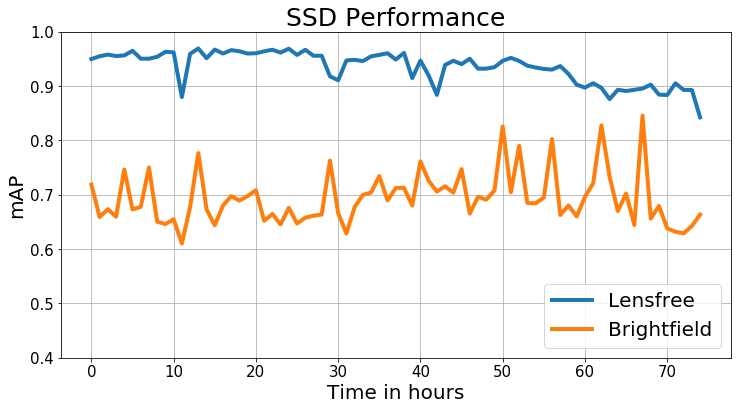

In [17]:
plt.plot(frames, lf_maps, lw=4, label="Lensfree")
# plt.plot(time, lf_fscores, lw=4, label="Lensfree")

plt.plot(frames, bf_maps, lw=4, label="Brightfield")
# plt.plot(time, bf_fscores, lw=4, label="Brightfield")

plt.title("SSD Performance", fontsize=25)
plt.xlabel("Time in hours", fontsize=20)
plt.ylabel("mAP", fontsize=20)
plt.yticks(np.linspace(0.4, 1, 7), fontsize=15)
plt.xticks(fontsize=15)
plt.legend(fontsize=20, loc="lower right")
plt.grid()

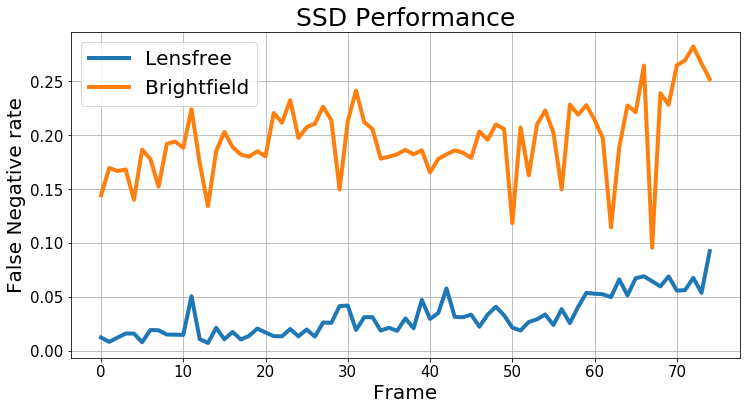

In [18]:
plt.plot(frames, lf_fnrs, lw=4, label="Lensfree")
plt.plot(frames, bf_fnrs, lw=4, label="Brightfield")
plt.title("SSD Performance", fontsize=25)
plt.xlabel("Frame", fontsize=20)
plt.ylabel("False Negative rate", fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(fontsize=20)
plt.grid()

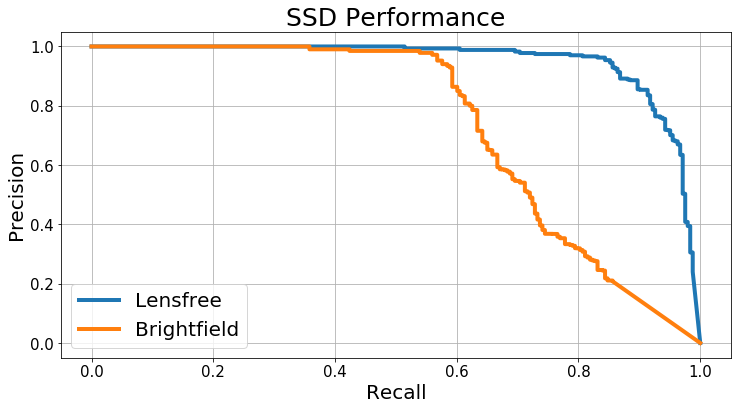

In [19]:
plt.title("SSD Performance", fontsize=25)
plt.plot(lf_metrics[0].get("recalls"), lf_metrics[0].get("precisions"), lw=4, label="Lensfree")
plt.plot(bf_metrics[0].get("recalls"), bf_metrics[0].get("precisions"), lw=4, label="Brightfield")
plt.xlabel("Recall", fontsize=20)
plt.ylabel("Precision", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
plt.legend(fontsize=20)
plt.show()

## Plot confusion matrix

In [152]:
lf_confusions = np.sum([(i.get("tp"), i.get("fp"), i.get("fn")) for i in lf_metrics], axis=0)
bf_confusions = np.sum([(i.get("tp"), i.get("fp"), i.get("fn")) for i in bf_metrics], axis=0)

In [153]:
lf_confusions = np.append(lf_confusions, 0).reshape((2, 2))
bf_confusions = np.append(bf_confusions, 0).reshape((2, 2))

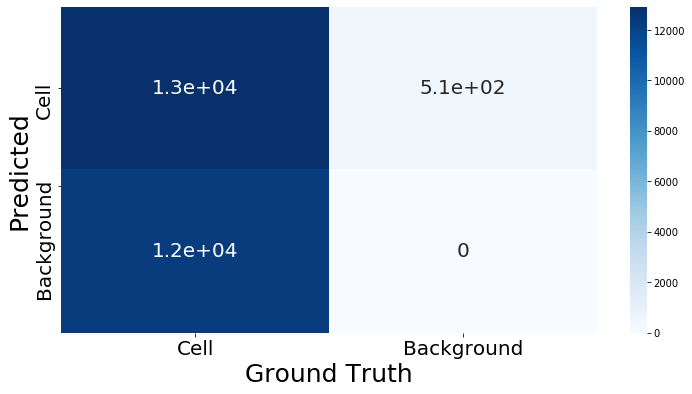

In [212]:
sns.heatmap(bf_confusions, annot=True, annot_kws={"fontsize": 20}, cmap="Blues")
plt.xlabel("Ground Truth", fontsize=25)
plt.ylabel("Predicted", fontsize=25)
plt.xticks(ticks=[0.5, 1.5], labels=["Cell", "Background"], fontsize=20)
plt.yticks(ticks=[0.5, 1.1], labels=["Cell", "Background"], fontsize=20)
plt.show()

Text(87.0, 0.5, 'Predicted')

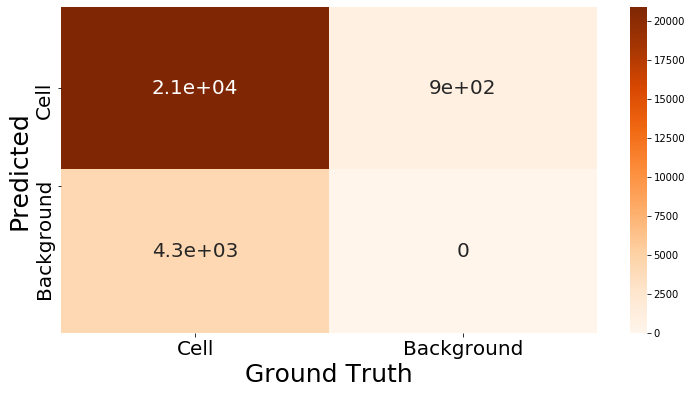

In [213]:
sns.heatmap(lf_confusions, annot=True, annot_kws={"fontsize": 20}, cmap="Oranges")
plt.xticks(ticks=[0.5, 1.5], labels=["Cell", "Background"], fontsize=20)
plt.yticks(ticks=[0.5, 1.1], labels=["Cell", "Background"], fontsize=20)
plt.xlabel("Ground Truth", fontsize=25)
plt.ylabel("Predicted", fontsize=25)

## Show predicted image

In [100]:
lf_val_data_generator = tf_dataset_generator(LF_DATA_PATH)
bf_val_data_generator = tf_dataset_generator(BF_DATA_PATH)

In [101]:
lf_query = next(lf_val_data_generator)
bf_query = next(bf_val_data_generator)

In [112]:
lf_pred = prediction_utils.run_inference_for_single_image(lf_model, lf_query.get("image"))
lf_pred_boxes = lf_pred.get("detection_boxes")[lf_pred.get("detection_scores") >= 0.5]

bf_pred = prediction_utils.run_inference_for_single_image(bf_model, bf_query.get("image"))
bf_pred_boxes = bf_pred.get("detection_boxes")[bf_pred.get("detection_scores") >= 0.5]

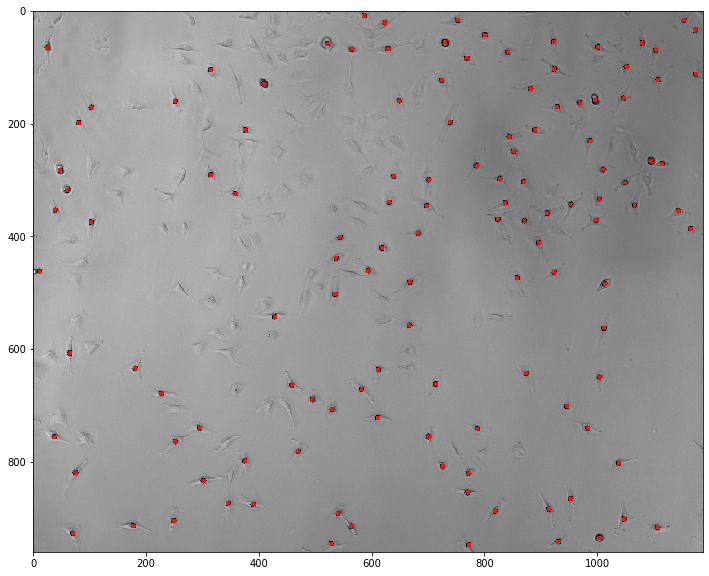

In [113]:
plot_circles_from_boxes(bf_query.get("image"), bf_pred_boxes)

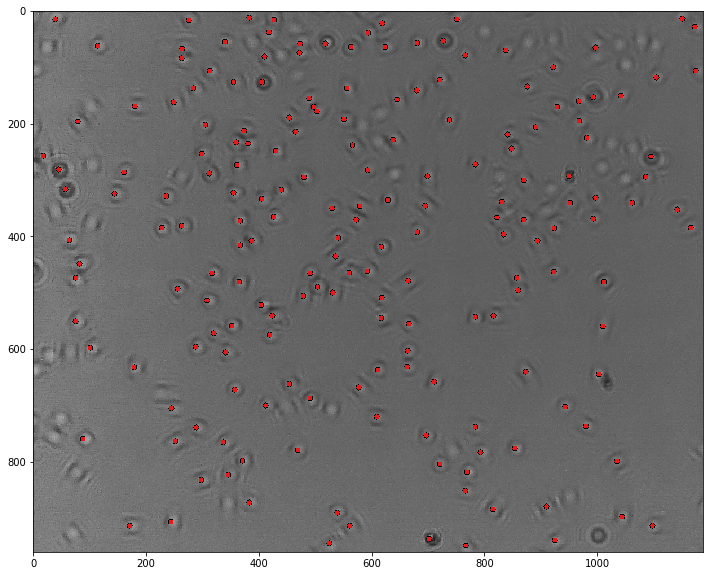

In [114]:
plot_circles_from_boxes(lf_query.get("image"), lf_pred_boxes)

# Evaluation on different confluencys

In [220]:
# Reload data generator. Must be brightfield, because confluency detection is based on simple filters.
lf_val_data_generator = tf_dataset_generator(LF_DATA_PATH)
bf_val_data_generator = tf_dataset_generator(BF_DATA_PATH)

In [221]:
confluencys = [simple_confluency.get_image_confluency(x.get("image")) for x in bf_val_data_generator]

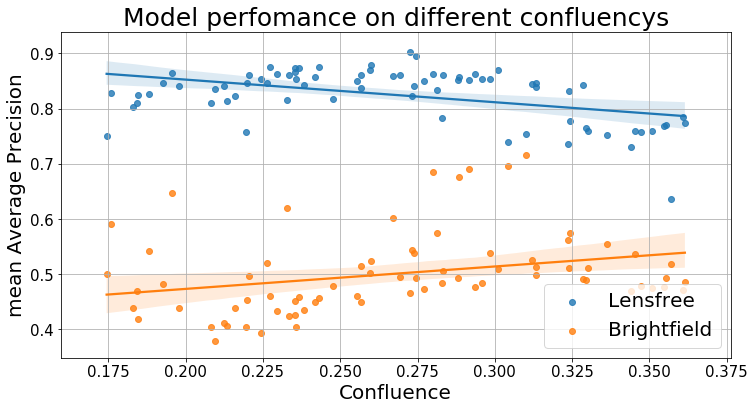

In [229]:
sns.regplot(confluencys, lf_maps, label="Lensfree")
sns.regplot(confluencys, bf_maps, label="Brightfield")
plt.title("Model perfomance on different confluencys", fontsize=25)
plt.xlabel("Confluence", fontsize=20)
plt.ylabel("mean Average Precision", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20, loc="lower right")
plt.grid()